# Neural Matrix Factorization

On this notebook we will implement NeuMF Architecture [Described Here](https://arxiv.org/pdf/1708.05031.pdf). This architectures features a generalization of Matrix Factorization called Generalized Matrix Factorization, and an MLP for Neural Collaborative Filtering. Both are connected by an parallel architecture mechanism.

For train the model, we will use Movie Lens 20 Million Dataset [avialable here](http://files.grouplens.org/datasets/movielens/ml-20m.zip).

The final output of this architecture predicts the probability of the supplied item to be relevant to supplied user.

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
!pip install wandb
clear_output()

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import zipfile
import requests

if(not os.path.exists("./Datasets/MoviLens20M.zip")):

  resp = requests.get("http://files.grouplens.org/datasets/movielens/ml-20m.zip")

  os.mkdir("./Datasets")

  with open("./Datasets/MoviLens20M.zip", "wb") as f:
    f.write(resp.content)

  with zipfile.ZipFile("./Datasets/MoviLens20M.zip", "r") as zip_ref:
    zip_ref.extractall("./Datasets")


In [0]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import wandb

from google.colab import drive
drive.mount('/content/drive')

wandb.login()

clear_output()

## Exploratory Data Analysis

Simple exploration without too much fancy graphs

In [4]:
#Loads Dataset, we only need ratings.csv and movies.csv files, we can drop timestamp and genres for now
ratings_df = pd.read_csv("./Datasets/ml-20m/ratings.csv").drop(["timestamp"], axis=1)
movies_df = pd.read_csv("./Datasets/ml-20m/movies.csv").drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")

ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head()

,userId,movieId,title,rating
0,1,2,Jumanji (1995),3.5
1,5,2,Jumanji (1995),3.0
2,13,2,Jumanji (1995),3.0
3,29,2,Jumanji (1995),3.0
4,34,2,Jumanji (1995),3.0


In [5]:
#Check info about the Dataset
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId     int64
movieId    int64
title      object
rating     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 762.9+ MB


In [6]:
#Check for NaNs
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [7]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 138493
Unique Movies: 26744


In [8]:
#Top movies with more rating count (dont confuse with more views or more rating score, but are correlated)
count = ml_df["title"].value_counts()
count[:15]

Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Toy Story (1995)                             49695
Fugitive, The (1993)                         49581
Apollo 13 (1995)                             47777
Independence Day (a.k.a. ID4) (1996)         47048
Usual Suspects, The (1995)                   47006
Name: title, dtype: int64

## Preprocessing

In [9]:
#Encode ratings, now will encode the probability of relevance of the item for the user
#The negative sampling ratio under this setup is almost 2.5, but can be better have a setup of 5.0 ratio
ml_df["relevance"] = (ml_df["rating"] >= 5.0).astype(dtype=float)

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values

ml_df.head()

,userId,movieId,title,rating,relevance
0,0,1,Jumanji (1995),3.5,0.0
1,4,1,Jumanji (1995),3.0,0.0
2,12,1,Jumanji (1995),3.0,0.0
3,28,1,Jumanji (1995),3.0,0.0
4,33,1,Jumanji (1995),3.0,0.0


In [10]:
#Shuffle Dataframe
ml_df = ml_df.sample(frac=1.0).reset_index(drop=True)
ml_df.head()

,userId,movieId,title,rating,relevance
0,37529,1169,One Flew Over the Cuckoo's Nest (1975),3.0,0.0
1,73647,1066,Dirty Dancing (1987),1.5,0.0
2,96128,1034,Get on the Bus (1996),4.0,0.0
3,84075,2215,"Producers, The (1968)",4.5,0.0
4,133354,954,Cat on a Hot Tin Roof (1958),4.0,0.0


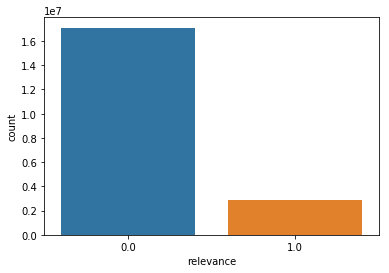

Negative Sampling Ratio: 5.89983061138595


In [11]:
#Test for negative sampling ratio, for this architecture a negative sampling ratio around 5.0 is very good
#based on the cited paper experiments https://arxiv.org/pdf/1708.05031.pdf
rel = (ml_df["relevance"] == 1.0).sum()
non_rel = (ml_df["relevance"] != 1.0).sum()

sns.countplot(x="relevance", data=ml_df)
plt.show()
print("Negative Sampling Ratio: " + str(non_rel / rel))

In [0]:
#Split dataset between train, eval and test
full_df = ml_df
eval_df = full_df.sample(frac=0.001)
full_df = full_df.drop(eval_df.index)
test_df = full_df.sample(frac=0.001)
train_df = full_df.drop(test_df.index)

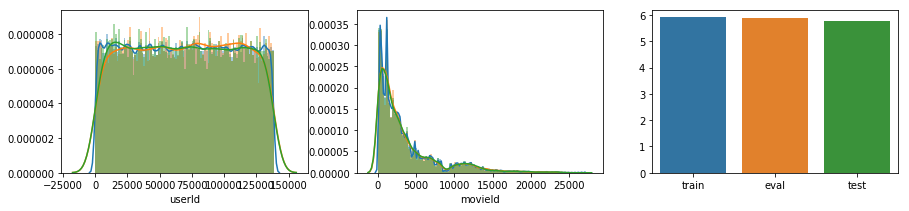

In [13]:
#Verify the distribution of the three splits
plt.figure(figsize=(15, 3))

#Verify users distributions
plt.subplot(1, 3, 1)
sns.distplot(a=train_df["userId"], bins=100)
sns.distplot(a=eval_df["userId"], bins=100)
sns.distplot(a=test_df["userId"], bins=100)

#Verify movies distributions
plt.subplot(1, 3, 2)
sns.distplot(a=train_df["movieId"], bins=100)
sns.distplot(a=eval_df["movieId"], bins=100)
sns.distplot(a=test_df["movieId"], bins=100)


#Verify Negative Sampling Ration Between the splits
plt.subplot(1, 3, 3)
train_nsr = (train_df["relevance"] == 0.0).sum() / (train_df["relevance"] == 1.0).sum()
eval_nsr = (eval_df["relevance"] == 0.0).sum() / (eval_df["relevance"] == 1.0).sum()
test_nsr = (test_df["relevance"] == 0.0).sum() / (test_df["relevance"] == 1.0).sum()
sns.barplot(x=["train", "eval", "test"], y=[train_nsr, eval_nsr, test_nsr])

plt.show()


Now that all the splits are balanced, let create the Tensorflow Datasets used for the training input pipeline

In [0]:
#Create Datasets for train, evaluation and testing
train_ds = tf.data.Dataset.from_tensor_slices(({"userId":train_df["userId"], "movieId":train_df["movieId"]}, train_df["relevance"].values.reshape([-1, 1])))
eval_ds = tf.data.Dataset.from_tensor_slices(({"userId":train_df["userId"], "movieId":train_df["movieId"]}, train_df["relevance"].values.reshape([-1, 1]))).batch(21000)
test_ds = tf.data.Dataset.from_tensor_slices(({"userId":train_df["userId"], "movieId":train_df["movieId"]}, train_df["relevance"].values.reshape([-1, 1]))).batch(21000)

## Generalized Matrix Factorization

On this section we will implement the GMF described [on this paper](https://arxiv.org/pdf/1708.05031.pdf).  This generalization introduces non-linearities and change dot product by element-wise product. Check the paper on GMF section for more details. I will write this model with reusability on mind, so you will be able to pick this and use it on your implementations easily. I will create a repo for this implementation later.

In [0]:
class GeneralizedMatrixFactorizer(tf.keras.Model):
  """
  Generalized Matrix Factorization Model 

  Element-wise Product of Embeddings instead of Dot Product
  Non-Linear Activation Capability

  Args:
    alpha (int): Represent the first Embedding Layer Max Tokens Size, on movie recommendation examples, this can be the max number of users
    beta (int): Represent the second Embedding Layer Max Tokens Size, on movie recommendation examples, this can be the max number of movies
    emb_dim (int): Dimension of the latent space representation of both Embedding Layers
    alpha_key (str): alpha is an independent input to the model, alpha_key is the key name in the call() input dictionary assigned to alpha, default="alpha"
    beta_key (str): beta is an independent input to the model, beta_key is the key name in the call() input dictionary assigned to beta, default="beta"

  """

  def __init__(self, alpha, beta, emb_dim, output_dim, alpha_key="alpha", beta_key="beta"):
    super(GeneralizedMatrixFactorizer, self).__init__()

    self.alpha_key = alpha_key
    self.beta_key = beta_key

    self.alpha_emb = tf.keras.layers.Embedding(alpha, emb_dim)
    self.alpha_bias = tf.keras.layers.Embedding(alpha, 1)

    self.beta_emb = tf.keras.layers.Embedding(beta, emb_dim)
    self.beta_bias = tf.keras.layers.Embedding(beta, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.mul = tf.keras.layers.Multiply()
    self.out = tf.keras.layers.Dense(output_dim, "sigmoid")

  def call(self, inputs):
    alpha_emb = self.alpha_emb(inputs[self.alpha_key])
    alpha_emb = self.flat(alpha_emb)
    alpha_bias = self.alpha_bias(inputs[self.alpha_key])
    alpha_bias = self.flat(alpha_bias)

    beta_emb = self.beta_emb(inputs[self.beta_key])
    beta_emb = self.flat(beta_emb)
    beta_bias = self.beta_bias(inputs[self.beta_key])
    beta_bias = self.flat(beta_bias)

    bias = tf.add(alpha_bias, beta_bias)
    X = self.mul([alpha_emb, beta_emb])
    X = tf.add(X, bias)
    X = self.out(X)
    return X

In [16]:
#Hyper-parameters
gmf_params = {"emb_dim":32,
              "learning_rate":0.002,
              "epochs":10,
              "batch_size":8192}
            
#Init wandb run/experiment
wandb.init(config=gmf_params, project="neural-matrix-factorization", group="GeneralizedMF")

W&B Run: https://app.wandb.ai/elpapi42/neural-matrix-factorization/runs/i2f8lks4

In [0]:
#Instantiation
gmf = GeneralizedMatrixFactorizer(n_users, n_movies, gmf_params["emb_dim"], output_dim=1, alpha_key="userId", beta_key="movieId")
gmf.compile(tf.keras.optimizers.Adam(gmf_params["learning_rate"]), tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

In [21]:
#Fitting
gmf.fit(train_ds.batch(gmf_params["batch_size"]), epochs=gmf_params["epochs"], validation_data=eval_ds, callbacks=[wandb.keras.WandbCallback(save_model=False)])

Epoch 1/10
2437/2437 [==============================] - 262s 108ms/step - loss: 0.3293 - binary_accuracy: 0.8633 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/10
2437/2437 [==============================] - 267s 109ms/step - loss: 0.2860 - binary_accuracy: 0.8785 - val_loss: 0.2474 - val_binary_accuracy: 0.8968
Epoch 3/10
2437/2437 [==============================] - 268s 110ms/step - loss: 0.2505 - binary_accuracy: 0.8945 - val_loss: 0.2097 - val_binary_accuracy: 0.9148
Epoch 4/10
2437/2437 [==============================] - 267s 109ms/step - loss: 0.2245 - binary_accuracy: 0.9067 - val_loss: 0.1897 - val_binary_accuracy: 0.9241
Epoch 5/10
2437/2437 [==============================] - 273s 112ms/step - loss: 0.2093 - binary_accuracy: 0.9140 - val_loss: 0.1779 - val_binary_accuracy: 0.9294
Epoch 6/10
2437/2437 [==============================] - 273s 112ms/step - loss: 0.1994 - binary_accuracy: 0.9186 - val_loss: 0.1700 - val_binary_accuracy: 0.9329
Epoch 7/10
2437/2437

In [22]:
gmf.evaluate(test_ds)

951/951 [==============================] - 47s 49ms/step - loss: 0.1541 - binary_accuracy: 0.9394


[0.15413242641182226, 0.9394148]

In [0]:
#Save weights for use later
path = "./drive/My Drive/NeuralMatrixFactorization/Checkpoints/GMF/"
name = wandb.run.name

if(not os.path.exists(path + name)):
  os.mkdir(path + name)
  gmf.save_weights(path + name + "/checkpoint")

!cp -r "./drive/My Drive/NeuralMatrixFactorization/Checkpoints" "."

## Naural Matrix Factorization

Lets implement this hybrid architecture, described [here](https://arxiv.org/pdf/1708.05031.pdf). It features a parallel architecture between a generalization of classic Matrix Factorization called Generalized Matrix Factorization, and Deep Feedforward Network, both of them feeded by its own Embeddings pair for users and items. [Check the paper](https://arxiv.org/pdf/1708.05031.pdf) for more details.

In [0]:
class DenseBlock(tf.keras.layers.Layer):
  """
  Dense Block Unit

  Features Batch Normalization, Dropout and Dense layers, in that order
  Created for convenient building of Deep Feedforward Networks

  Args:
    units (int): Number of units on Dense Layer
    dropout (float): % of inputs to drop from Batch Normalization Layer
    l2 (float): Strenght of L2 regularization on Dense Layer

  """

  def __init__(self, units, dropout=0.1, l2=0.001):
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       "relu",
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

In [0]:
class DeepFeedForward(tf.keras.Model):
  """
  Multi-Layer Perceptron
  """

  def __init__(self, layers, dropout=0.1, l2=0.001):
    super(DeepFeedForward, self).__init__()

    self.block_list = list()
    for layer in layers:
      self.block_list.append(DenseBlock(layer, dropout, l2))
    
  def call(self, inputs):
    X = inputs

    for layer in self.dense_list:
      X = layer(X)

In [0]:
class NeuMF(tf.keras.Model):
  """Neural Matrix Factorizer"""

  def __init__(self):
    super(NeuMF, self).__init__()